In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
def load_history_rest2(filepath):
    data = pd.read_csv(filepath, sep="\s+", header=None)
    data.columns = ["timestep", "temp_idx", "temp", "potential"]
    return data


def load_history_remd(filepath):
    data = pd.read_csv(filepath, sep="\s+", header=None)
    data.columns = ["timestep", "temp_idx", "newtemp", "temp", "potential"]
    return data


def parse_replica_dirs(output_dir):
    replica_dirs = glob.glob(os.path.join(output_dir, "*"))
    replica_dirs = [d for d in replica_dirs if os.path.isdir(d)]
    replica_dirs.sort(key=lambda d: os.path.basename(d))
    return replica_dirs


def parse_history_files(output_dir, jobname, suffix=".history"):
    replica_dirs = parse_replica_dirs(output_dir)
    results = []
    for rep_dir in replica_dirs:
        files = glob.glob(os.path.join(rep_dir, "*" + suffix))
        files = [f for f in files if os.path.isfile(f)]
        files = [f for f in files if jobname in f]
        assert len(files) == 1, "Files found: " + ", ".join(files)
        
        results.append(files[0])
    return results


def groupby_temp(history_dfs, temp_idx_col="temp_idx"):
    assert isinstance(history_dfs, list), "history_dfs must be a list of dataframes"
    nreplicas = len(history_dfs)
    ntemps = nreplicas 
    
    dfs_temp = []
    for tem_idx in range(ntemps):
        
        dfs_rep = []
        for rep_idx in range(nreplicas):
            df = history_dfs[rep_idx].copy()
            df = df.loc[df[temp_idx_col] == tem_idx, :]
            df["rep_idx"] = rep_idx
            dfs_rep.append(df)
        
        df_temp = pd.concat(dfs_rep, axis=0)
        df_temp = df_temp.reset_index(drop=True)
        
        dfs_temp.append(df_temp)
    return dfs_temp

# Temperature replica exchange

In [4]:
inp_dir = "/home/hai/Learning/NAMD/replica/example/output_1"
hist_files = parse_history_files(inp_dir, "job0")
hist_files

['/home/hai/Learning/NAMD/replica/example/output_1/0/fold_alanin.job0.0.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/1/fold_alanin.job0.1.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/2/fold_alanin.job0.2.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/3/fold_alanin.job0.3.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/4/fold_alanin.job0.4.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/5/fold_alanin.job0.5.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/6/fold_alanin.job0.6.history',
 '/home/hai/Learning/NAMD/replica/example/output_1/7/fold_alanin.job0.7.history']

In [6]:
histories_by_rep = [load_history_remd(f) for f in hist_files]
histories_by_temp = groupby_temp(histories_by_rep)

In [7]:
histories_by_rep[0].head()

,timestep,temp_idx,newtemp,temp,potential
0,1000,0,300.00,271.815255,-130.870227
1,2000,1,331.23,354.181703,-138.227738
2,3000,2,365.70,420.672311,-111.596721
3,4000,3,403.77,383.301140,-116.393730
4,5000,3,403.77,346.960365,-118.243271


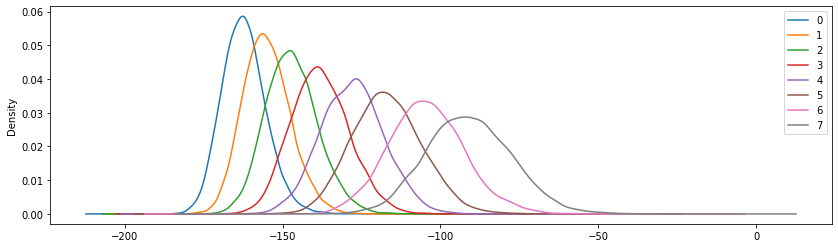

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 4))

for idx, df in enumerate(histories_by_temp):
    df["potential"].plot(kind="kde", ax=ax, label=str(idx))

ax.legend()